In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import pickle

In [2]:
import matplotlib.pyplot as plt

In [3]:
log_dir = Path('/Users/mairas/BTSync/Shared/hurma_data/sk-data-log')

In [4]:
pddata_fn = log_dir / 'pddata.pickle'

In [5]:
pddata = pickle.load(pddata_fn.open('rb'))

In [6]:
circ_units = {
    'environment.wind.angleApparent',
    'navigation.courseOverGroundTrue',
    'navigation.headingMagnetic',
    'navigation.headingTrue',
}

In [7]:
def circ_mean(alpha):
    return np.arctan2(np.sum(np.sin(alpha)), np.sum(np.cos(alpha)))


def angle_diff(alpha, beta):
    return (beta - alpha + np.pi) % (2*np.pi) - np.pi


def circ_std(alpha, mean=None):
    if mean is None:
        mean = circ_mean(alpha)
    return np.sqrt((np.sum(angle_diff(mean, alpha)**2))/len(alpha))

In [8]:
def resample(ser, period, circular=False):
    if circular:
        mean = ser.groupby(pd.Grouper(freq=period)).apply(circ_mean)
        std = ser.groupby(pd.Grouper(freq=period)).apply(circ_std)
    else:
        mean = ser.resample(period).mean()
        std = ser.resample(period).std()
    return pd.DataFrame.from_dict({
        ser.name: mean,
        ser.name + '.std': std
    })

In [9]:
def resample_all(ser_dict, period, circ_units):
    resampled = {}
    for k, v in ser_dict.items():
        print(k)
        resampled[k] = resample(v, period, k in circ_units)
    return pd.concat(resampled.values(), axis=1)
    #return resampled

In [10]:
df = resample_all(pddata, '5S', circ_units)

navigation.position.longitude
navigation.position.latitude
environment.water.temperature
navigation.headingMagnetic


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


navigation.speedOverGround
navigation.courseOverGroundTrue
environment.wind.speedApparent
environment.wind.angleApparent
propulsion.port.exhaustTemperature
propulsion.port.temperature
propulsion.port.coolantTemperature
environment.depth.belowSurface
navigation.speedThroughWater
navigation.magneticVariation
navigation.rateOfTurn
navigation.headingTrue


In [11]:
def kn(x):
    return 3.6 / 1.852 * x

def celsius(x):
    return x - 273.15

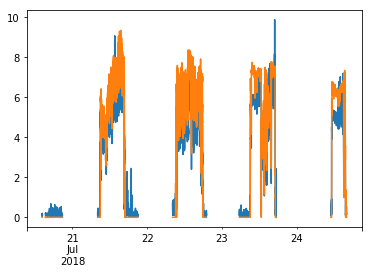

In [12]:
kn(df['navigation.speedOverGround']).plot()
kn(df['navigation.speedThroughWater']).plot()

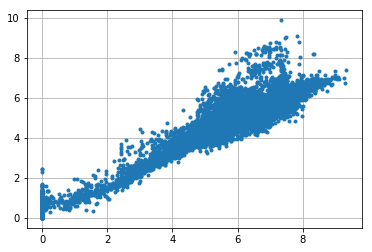

In [13]:
plt.figure()
plt.plot(kn(df['navigation.speedThroughWater']), kn(df['navigation.speedOverGround']), '.')
plt.grid()

In [15]:
from sklearn import linear_model

In [16]:
dfn = df.dropna()

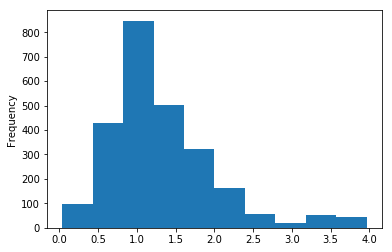

In [17]:
dfn['navigation.speedOverGround.std'].plot.hist()

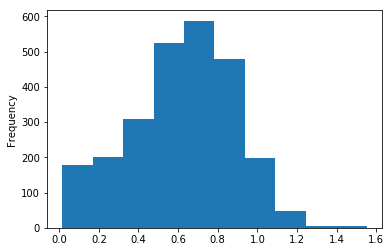

In [18]:
dfn['navigation.courseOverGroundTrue.std'].plot.hist()

In [19]:
dfc = dfn.loc[np.logical_and(dfn['navigation.speedOverGround.std']<1,
                             dfn['navigation.courseOverGroundTrue.std']<0.5)]

In [20]:
stw = dfc['navigation.speedThroughWater']
sog = dfc['navigation.speedOverGround']

In [21]:
X = np.array([stw, stw**2]).T
y = np.array(sog)

In [22]:
lm = linear_model.LinearRegression(fit_intercept=False)
model = lm.fit(X, y)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [23]:
model

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [24]:
def get_X_matrix(vector):
    return np.concatenate((vector.reshape(-1, 1), 
                           vector.reshape(-1, 1)**2), 
                          axis=1)

In [25]:
Xvec = np.arange(0, 5, step=0.1)

In [26]:
Xp = get_X_matrix(Xvec)

In [27]:
yp = lm.predict(Xp)

In [28]:
lm.score(X, y)

0.9223670954488472

In [29]:
lm.coef_

array([ 1.09295827, -0.08635961])

In [30]:
lm.intercept_

0.0

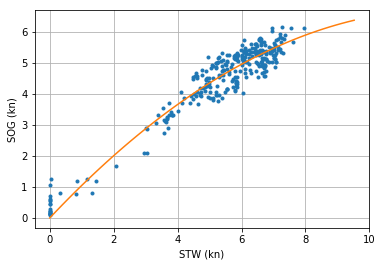

In [37]:
plt.figure()
plt.plot(kn(stw), kn(sog), '.')
plt.plot(kn(Xvec), kn(yp))
plt.xlabel('STW (kn)')
plt.ylabel('SOG (kn)')
plt.grid()

In [32]:
dfs = dfc.loc[dfc['navigation.speedThroughWater']>1]  # units: m/s

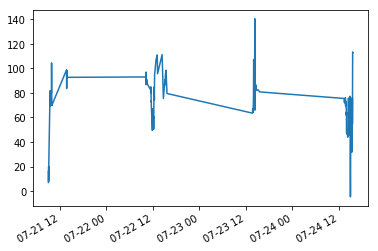

In [33]:
np.degrees(dfs["navigation.headingMagnetic"]).plot()

Text(0, 0.5, 'Deviation (degrees)')

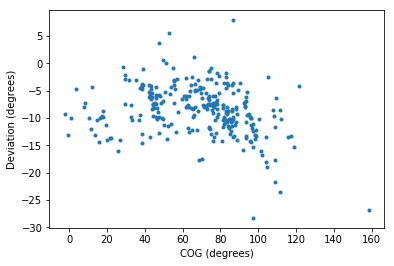

In [39]:
head_true = angle_diff(dfs["navigation.magneticVariation"], dfs["navigation.headingMagnetic"])
ad = np.degrees(angle_diff(dfs["navigation.courseOverGroundTrue"], head_true))
plt.figure()
plt.plot(np.degrees(dfs["navigation.courseOverGroundTrue"]), ad, '.')
plt.xlabel('COG (degrees)')
plt.ylabel('Deviation (degrees)')